# Audio Study

## First libraries and variables import

In [51]:
import sys
from pathlib import Path
import os
import pandas as pd

# Get the absolute path of the folder containing the module
root_dir = Path.cwd().resolve().parent.parent

# Add the folder path to sys.path
sys.path.append(str(root_dir))

import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import sklearn.preprocessing

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

In [52]:
from config.variables import indiv_sample_path, audio_path, text_path, wav_path, csv_file, audiocsv_file

from audio_utils import convert_to_wav, transcribe_audio, normalize, WavFileHelper, open_csv_file, load_audio_features, fetch_virality

ImportError: cannot import name 'normalize' from 'audio_utils' (c:\Users\juanl\Documents\Master\2o cuatri\ADNE\Trabajo\Tik Tok\src\audio\audio_utils.py)

## Speech extraction

First of all, we extract the speech from the audios, using one of the best pretrained models for this work. It is important to highlight that this step is not one of the main points of the project. For that reason, there will not be experimentation with different models of the rest of the phases.

In [ ]:
# Directory containing the audio files
audio_folder = os.path.join(root_dir, audio_path)
wav_folder = os.path.join(root_dir, wav_path)

# # Directory where the transcribed text files will be saved
# output_folder = os.path.join(root_dir, text_path)

# # Create the output directory if it doesn't exist
# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)

# # Iterate over the audio files in the folder
# for filename in os.listdir(audio_folder):
#     if filename.endswith('.mp3'):  # You can adjust the extension according to your audio files
#         audio_file = os.path.join(audio_folder, filename)
#         wav_file = convert_to_wav(audio_file, wav_folder)
#         text = transcribe_audio(wav_file)
        
#         output_file = os.path.splitext(filename)[0] + '.txt'
#         output_path = os.path.join(output_folder, output_file)
#         with open(output_path, 'w') as f:
#             f.write(text)
#         print(f"Transcription of {filename} saved to {output_file}")

## Data Exploration 

### Example of data inspection

In [ ]:
indiv_path = os.path.join(root_dir, indiv_sample_path)

ipd.Audio(indiv_path)

**Waveform**

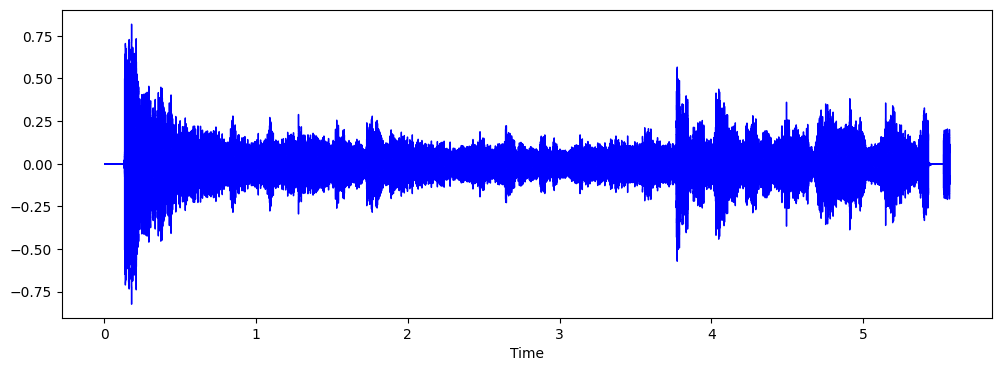

In [ ]:
plt.figure(figsize=(12,4))
data,sample_rate = librosa.load(indiv_path)
_ = librosa.display.waveshow(data,sr=sample_rate, color="blue")  
ipd.Audio(indiv_path)

**Spectogram**

In [ ]:
x , sr = librosa.load(indiv_path)

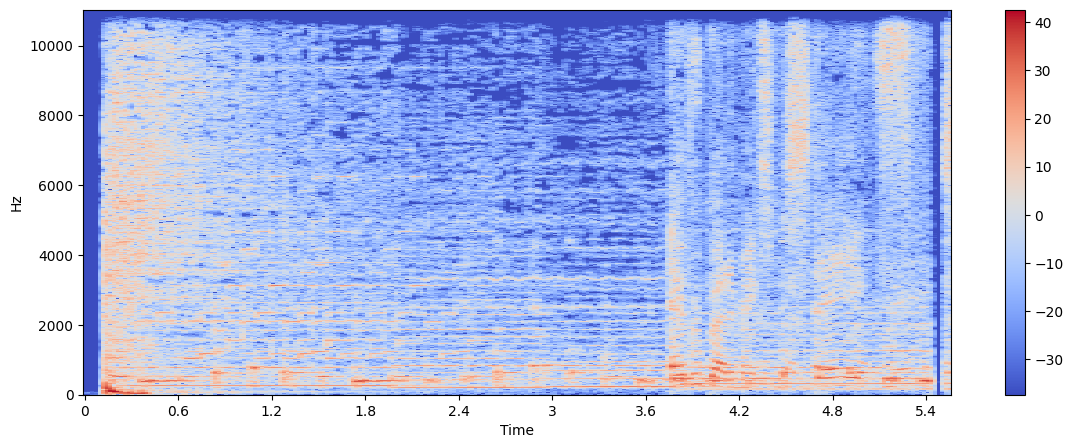

In [ ]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

**Log Frequency Axis**

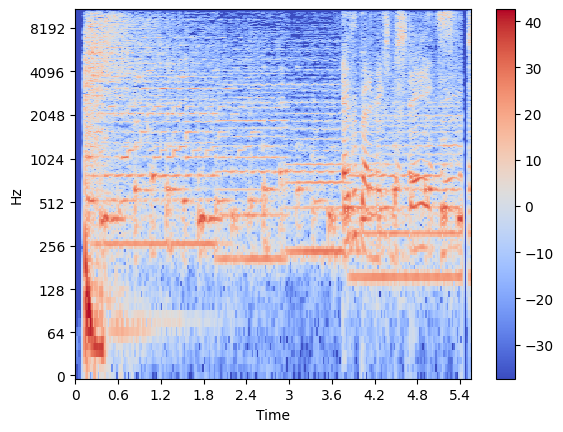

In [ ]:
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

### Dataset output addition

In [ ]:
# Load the CSV file into a DataFrame
csv_path = os.path.join(root_dir, csv_file)
df = pd.read_csv(csv_path)

df = df[['id', 'norm_virality']]

df['id'] = df['id'].astype(str)

# Display the DataFrame
df.head()

,id,norm_virality
0,6907228749016714497,0.000177
1,6875468410612993286,0.003337
2,6898699405898059010,0.060929
3,6902819837345533186,0.000377
4,6905635666588192002,0.000457


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1000 non-null   object 
 1   norm_virality  1000 non-null   float64
dtypes: float64(1), object(1)
memory usage: 15.8+ KB


### Audio sample file properties

The next step will be the extraction of the number of audio channels, sample rate and bit-depth. This could be useful for data estandarization before the feature extraction, maybe for a multimodal model with features from text, audio and video.

In [ ]:
wavfilehelper = WavFileHelper()

audiodata = []
for index, row in df.iterrows():

    file_name = os.path.join(wav_folder, f"{row['id']}_audio.wav")
    data = wavfilehelper.read_file_properties(file_name)
    audiodata.append(data)

# Convert into a Panda dataframe
audiodf = pd.DataFrame(audiodata, columns=['num_channels','sample_rate','bit_depth'])

In [ ]:
audiodf

,num_channels,sample_rate,bit_depth
0,1,16000,16
1,1,16000,16
2,1,16000,16
3,1,16000,16
4,1,16000,16
...,...,...,...
995,1,16000,16
996,1,16000,16
997,1,16000,16
998,1,16000,16


As it is easily observed, due to the fact that all the videos come from the same source, the format is consistent across videos, so not preprocessing of bit-depth, sample-rate or number of channels is required.

## Feature extraction

The next step is feature extraction, which could help in understanding the data and creating models, as previously mentioned. It will be carried out for an example sample to understand how it works, and will later be extended to the entire data set.

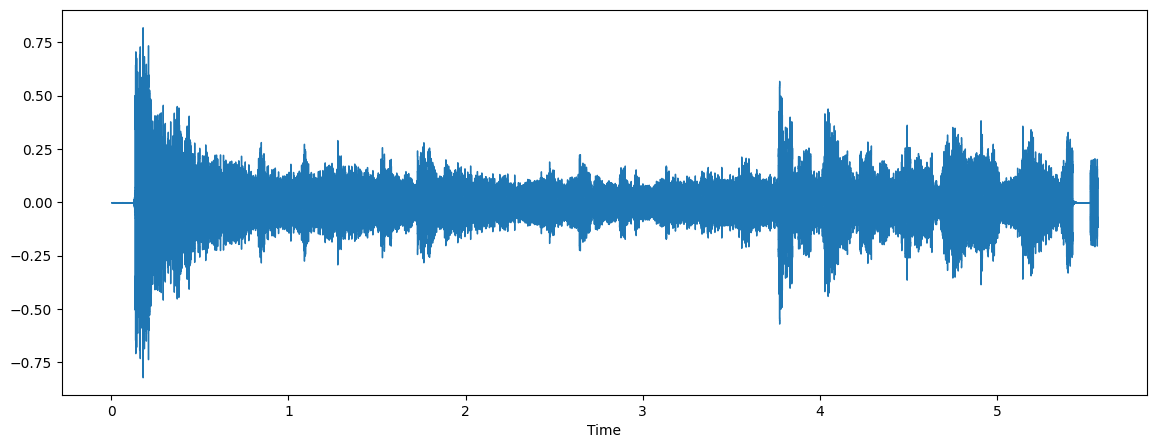

In [ ]:
#Plot the signal:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)

### 1. Zero Crossing Rate

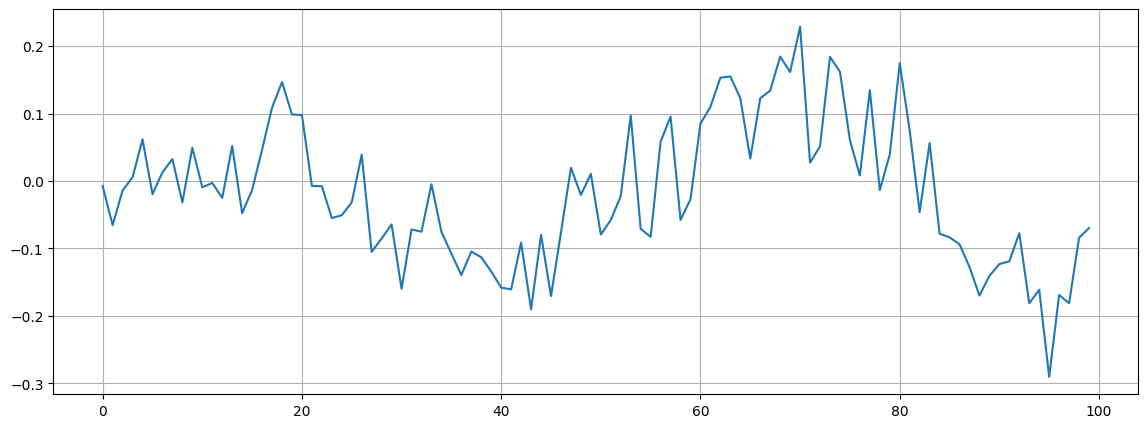

In [ ]:
# Zooming in
n0 = 9000
n1 = 9100
plt.figure(figsize=(14, 5))
plt.plot(x[n0:n1])
plt.grid()

More than 10 easily spotted.

In [ ]:
zero_crossings = librosa.zero_crossings(x[n0:n1], pad=False)
print(zero_crossings.shape)

print(sum(zero_crossings))

(100,)
26


### 2.Spectral Centroid

In [ ]:
spectral_centroids = librosa.feature.spectral_centroid(y=x, sr=sr)[0]
spectral_centroids.shape

(240,)

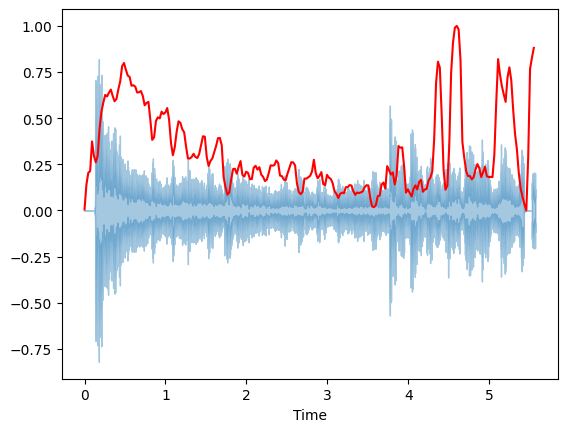

In [59]:
# Computing the time variable for visualization
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

#Plotting the Spectral Centroid along the waveform
librosa.display.waveshow(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')

### 3.Spectral Rolloff 

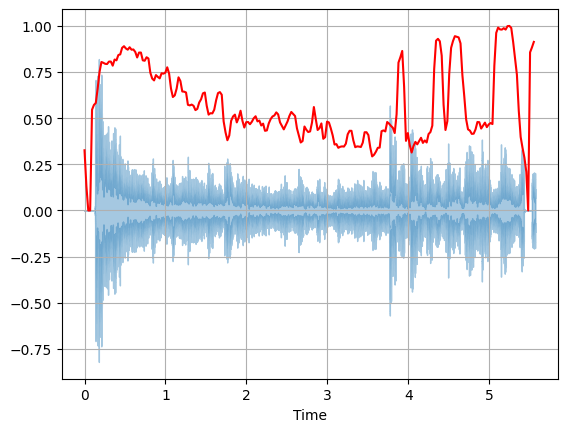

In [61]:
spectral_rolloff = librosa.feature.spectral_rolloff(y=x+0.01, sr=sr)[0]
librosa.display.waveshow(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')
plt.grid()

### 4.MFCC

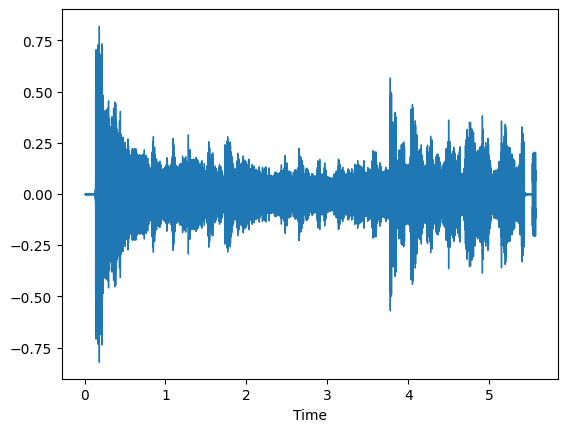

In [62]:
librosa.display.waveshow(x, sr=sr)

(20, 240)


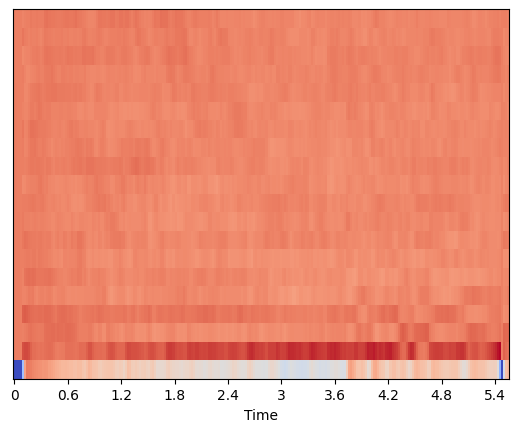

In [64]:
# MFCC
mfccs = librosa.feature.mfcc(y=x, sr=sr)
print(mfccs.shape)

librosa.display.specshow(mfccs, sr=sr, x_axis='time')

### MMFC Feature Scaling

In [66]:
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
print(mfccs.mean(axis=1))
print(mfccs.var(axis=1))

[-5.9604646e-09  0.0000000e+00  0.0000000e+00  0.0000000e+00
  1.5894573e-08 -3.1789146e-08 -1.5894573e-08  7.9472864e-09
 -7.9472864e-09  0.0000000e+00  1.5894573e-08  3.1789146e-08
  0.0000000e+00  0.0000000e+00 -1.5894573e-08  0.0000000e+00
  1.9868216e-09  0.0000000e+00  0.0000000e+00  0.0000000e+00]
[0.9999999  1.         0.9999999  0.99999994 1.0000001  1.0000001
 1.         1.         1.0000001  1.0000001  1.         1.
 1.         0.99999994 1.         1.0000001  0.99999994 1.0000002
 0.9999999  0.99999994]


c:\Users\juanl\Documents\Master\2o cuatri\ADNE\Trabajo\Tik Tok\tiktok\Lib\site-packages\sklearn\preprocessing\_data.py:261: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\juanl\Documents\Master\2o cuatri\ADNE\Trabajo\Tik Tok\tiktok\Lib\site-packages\sklearn\preprocessing\_data.py:280: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


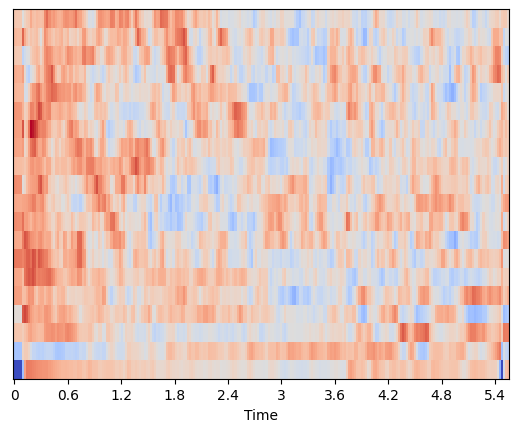

In [67]:
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

### 5. Chroma Frequencies

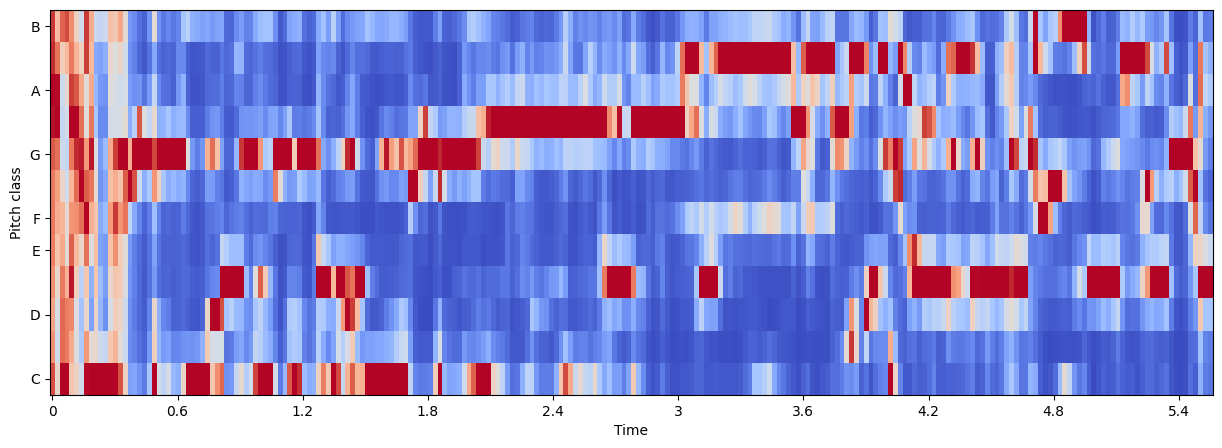

In [68]:
hop_length = 512
chromagram = librosa.feature.chroma_stft(y=x, sr=sr, hop_length=hop_length)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

## Complete Feature Extraction

It will be extracted:

 + Mel-frequency cepstral coefficients (MFCC)(20 in number. From the literature the first 13th are the most representative)

 + Spectral Centroid

 + Zero Crossing Rate

 + Chroma Frequencies

 + Spectral Roll-off

In [80]:
header = 'filename chroma_stft spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

The data will be written to a csv file, as well as the text embeddings, for an easier manipulation and code reproduction.

In [83]:
# Open the new CSV file for writing and write the header
audio_csv = os.path.join(root_dir, audiocsv_file, "audio_features.csv")

# csv writing
# file, writer = open_csv_file(audio_csv, header)

# # Iterate over the WAV files in the folder
# for filename in os.listdir(wav_folder):
#     if filename.endswith('.wav'):  # Adjust file extension if necessary
#         audio_name = os.path.join(wav_folder, filename)
        
#         # Extract video ID from filename
#         video_id = os.path.splitext(filename)[0].split('_')[0]

#         # Load audio features
#         features = load_audio_features(audio_name)

#         # Fetch virality label
#         virality_label = fetch_virality(video_id, df)

#         # Write features and virality label to CSV
#         to_append = f'{video_id} ' + ' '.join(map(str, features)) + f' {virality_label}'
#         writer.writerow(to_append.split())

# # Close the CSV file
# file.close()

## Csv Feature Reading and Treatment

In [105]:
data = pd.read_csv(audio_csv)
data

,filename,chroma_stft,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,6875317312082201857,0.445574,2747.258011,2020.649122,5297.622403,0.189092,-107.400795,75.834880,-80.086720,28.676441,...,-10.352499,7.441584,-10.581148,8.364483,-4.660430,15.533567,0.937928,10.310131,-3.240670,0.000805
1,6875323773755657474,0.333135,1812.114134,1580.771499,3446.998260,0.106621,-262.609740,120.351950,-31.681631,49.745846,...,-15.107998,13.919560,-10.353311,-0.775463,-3.052701,-3.336031,-6.546474,-2.021772,-1.373575,0.000189
2,6875342937002085633,0.400266,1944.360603,1560.395954,3507.649066,0.115429,-310.880250,126.661850,-46.500230,27.055515,...,0.213525,15.128963,-5.700875,10.273509,-2.030400,6.179650,1.224256,5.150634,0.197958,0.001499
3,6875370613523909890,0.295180,2116.037533,1934.255173,4351.187439,0.120654,-188.172990,107.782160,-39.465355,43.778110,...,-10.360028,1.580873,-17.704420,1.120645,-13.720979,5.554143,-6.436055,2.772507,-3.352244,0.000086
4,6875373441432816898,0.292295,2113.518369,1797.010900,4164.664334,0.122701,-236.509720,97.107090,-63.896763,35.321415,...,-12.574279,1.397874,-15.371344,13.029241,-4.472447,18.715902,4.007404,7.794216,-1.417918,0.000257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,6908391851418471682,0.318562,2013.462608,1753.406782,3887.673994,0.123730,-280.911130,75.836140,-20.778652,30.153076,...,-5.502901,-6.103394,-7.896830,3.484443,-11.787608,4.184449,-2.231119,1.629682,4.443437,0.000899
996,6908401262065143045,0.322200,1949.651372,1664.405063,3664.691418,0.119145,-89.844240,118.078300,-60.389492,32.610596,...,-12.539471,0.364483,-21.038690,1.485123,-14.048548,-6.210596,-3.521737,-1.809716,-6.371041,0.000135
997,6908408424610974977,0.568037,3671.581368,2131.155298,6289.955477,0.333884,-249.100570,71.439095,-70.545770,67.354620,...,-10.483207,4.051190,-25.192488,15.851523,-13.278896,14.087984,-15.423230,4.256517,-12.225366,0.000356
998,6908460695461891329,0.412975,1303.624803,1478.083481,2791.345729,0.065727,-429.450350,120.374680,-1.514547,53.847970,...,-3.388240,-6.735516,-3.014581,1.582657,-5.186983,-2.027671,-1.752960,-3.153165,-1.703576,0.000088


In [106]:
# Dropping unneccesary columns
data = data.drop(['filename'],axis=1)

In [108]:
# Scaling the Feature columns
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))
y = np.array(data['label'])

In [109]:
X_train, X_Test, y_train, y_Test = train_test_split(X, y, test_size=0.2, random_state=42)

X_valid, X_test, y_valid, y_test = train_test_split(X_Test, y_Test, test_size=0.5, random_state=42)